File: sub-OAS30193_ses-d0043_task-rest_space-T1w_boldref.nii.gz
Shape: (39, 48, 39)
Dimensions: 3


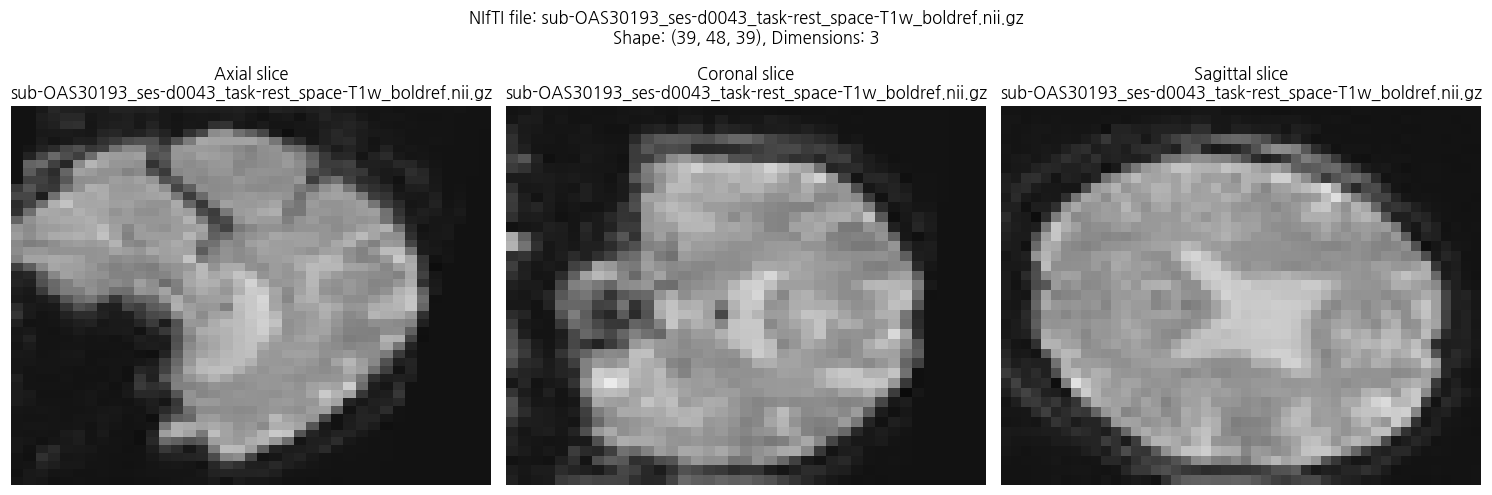

File: sub-OAS30193_ses-d0043_task-rest_desc-hmc_boldref.nii.gz
Shape: (64, 64, 36)
Dimensions: 3


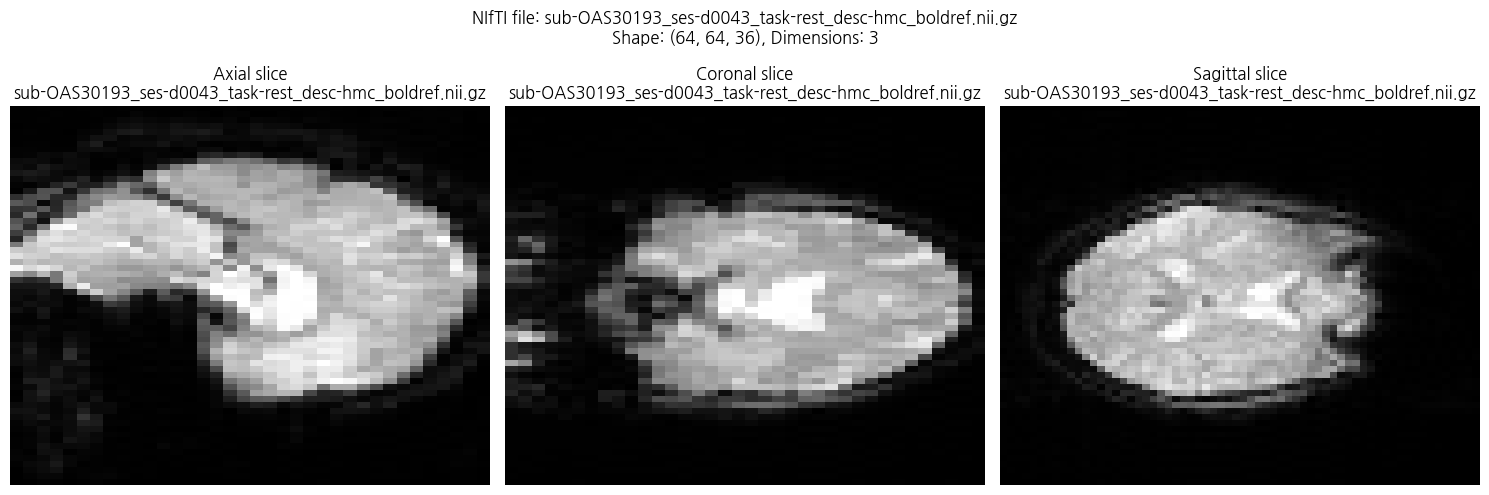

File: sub-OAS30193_ses-d0043_task-rest_desc-coreg_boldref.nii.gz
Shape: (64, 64, 36)
Dimensions: 3


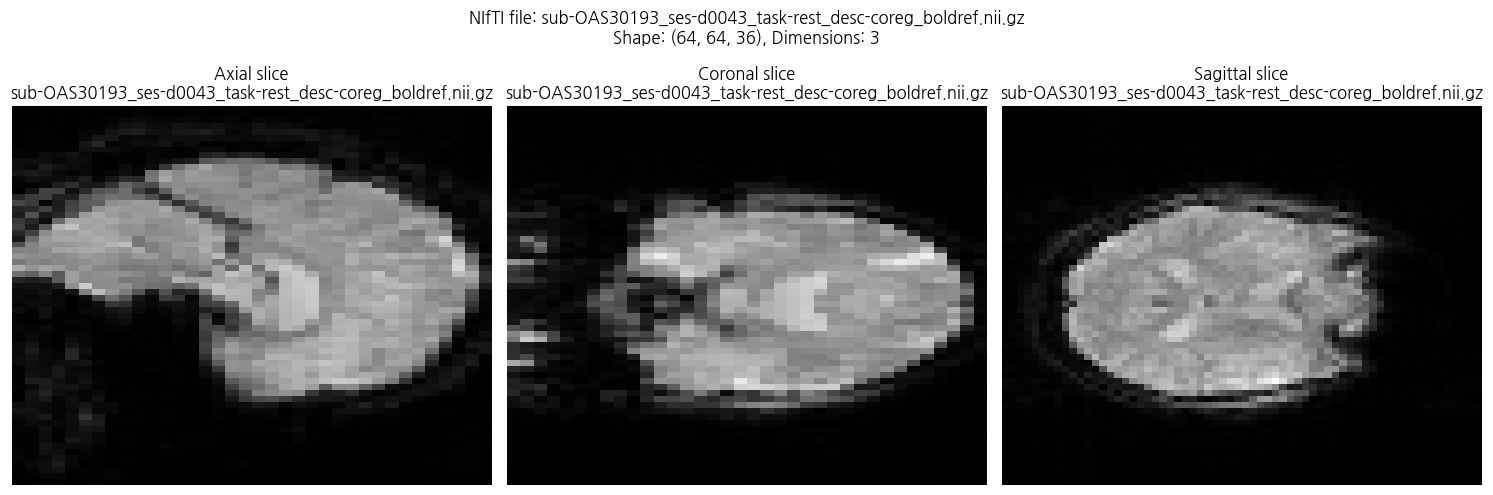

File: sub-OAS30193_ses-d0043_task-rest_space-T1w_desc-brain_mask.nii.gz
Shape: (39, 48, 39)
Dimensions: 3


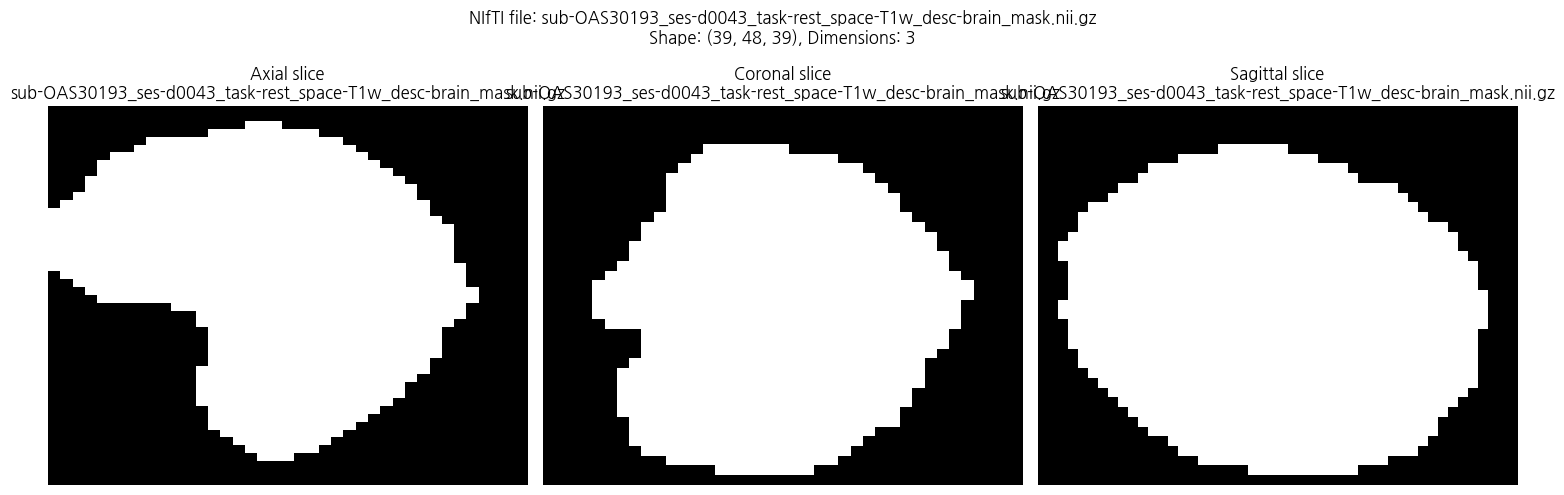

File: sub-OAS30193_ses-d0043_task-rest_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
Shape: (41, 50, 43)
Dimensions: 3


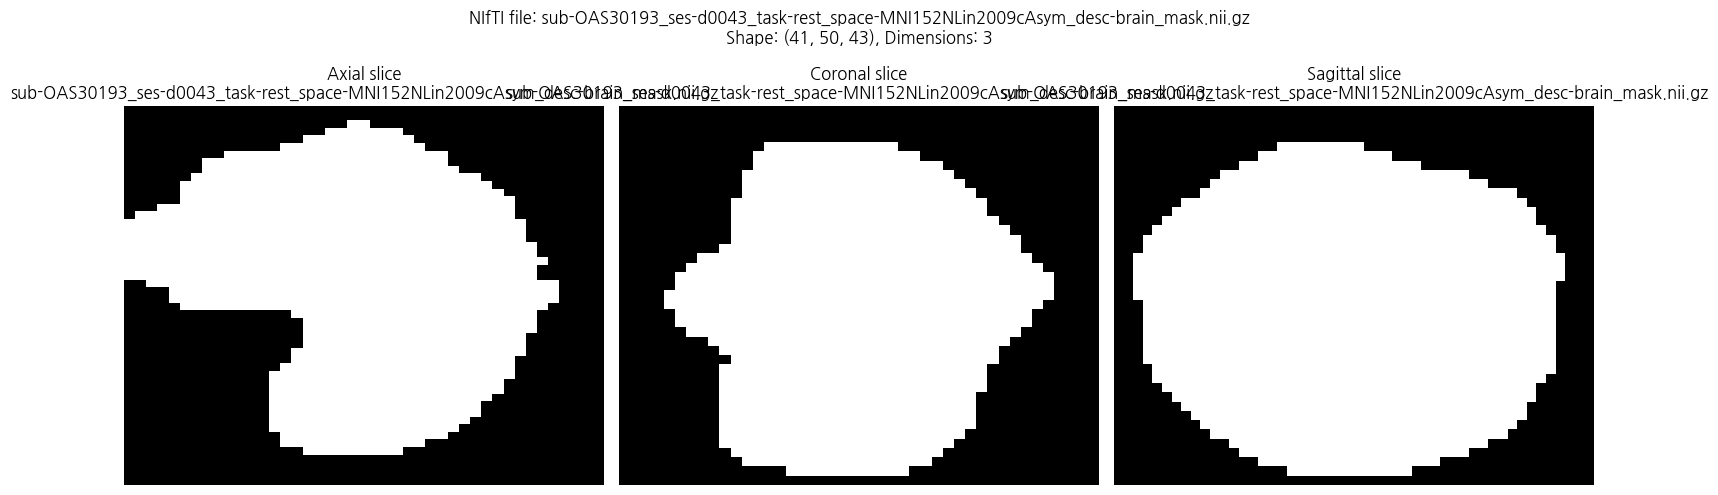

File: sub-OAS30193_ses-d0043_task-rest_space-T1w_desc-preproc_bold.nii.gz
Shape: (39, 48, 39, 164)
Dimensions: 4


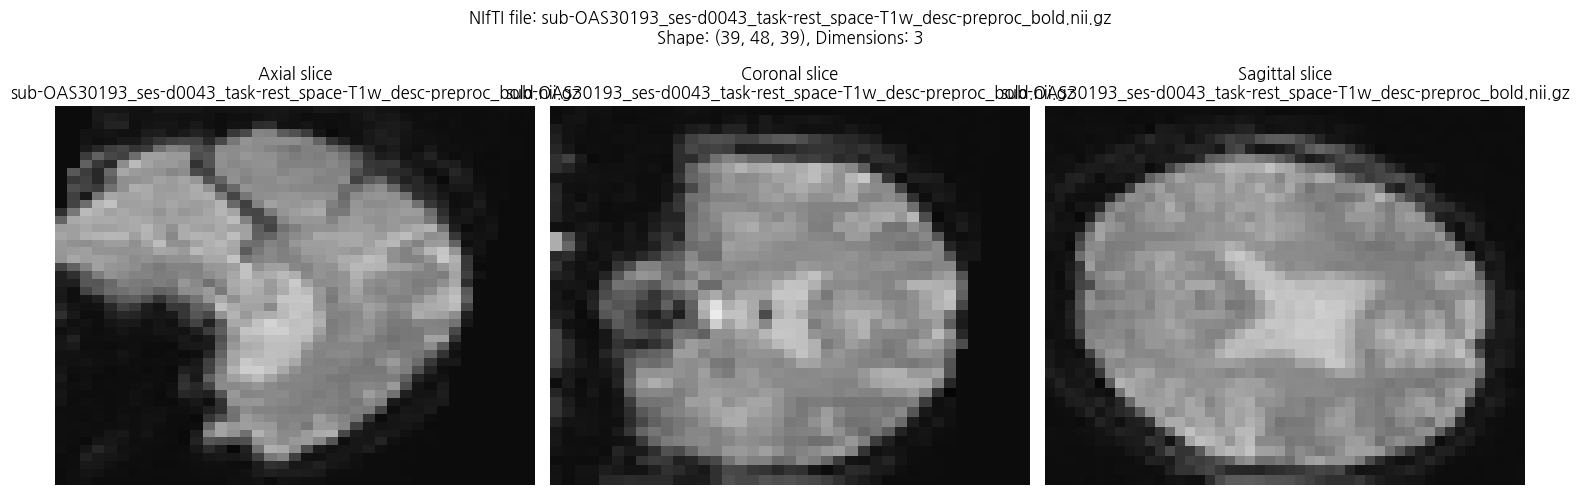

File: sub-OAS30193_ses-d0043_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Shape: (41, 50, 43, 164)
Dimensions: 4


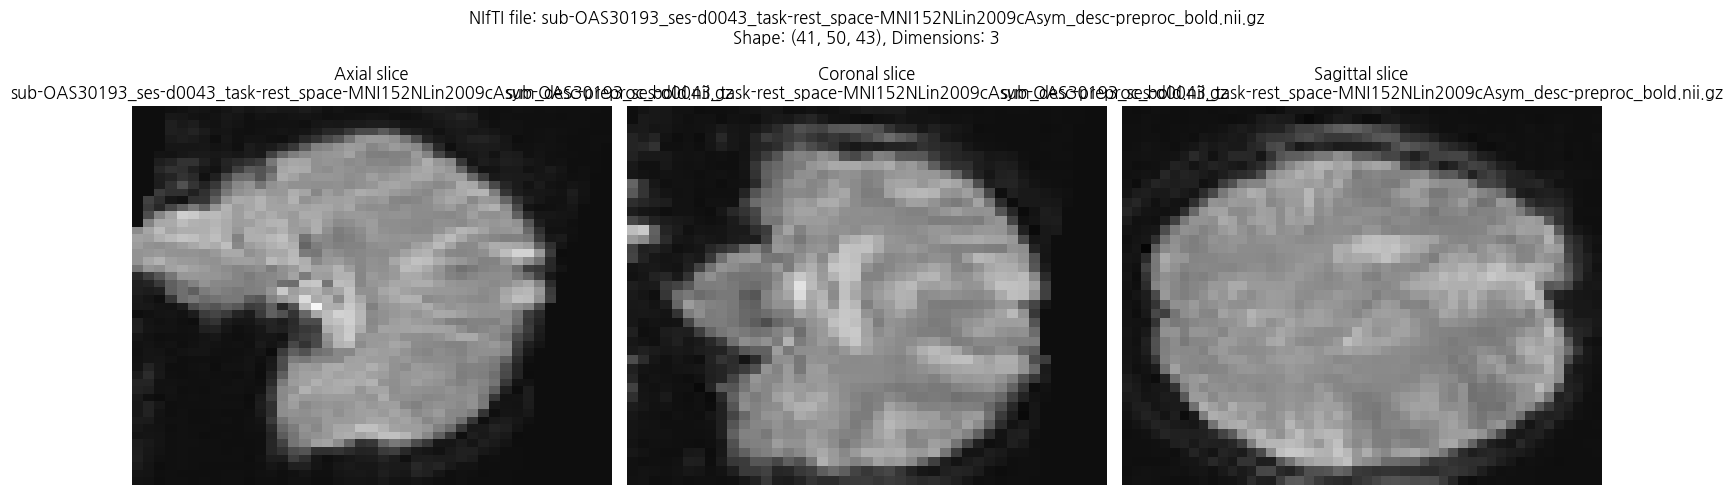

File: sub-OAS30193_ses-d0043_task-rest_space-MNI152NLin2009cAsym_boldref.nii.gz
Shape: (41, 50, 43)
Dimensions: 3


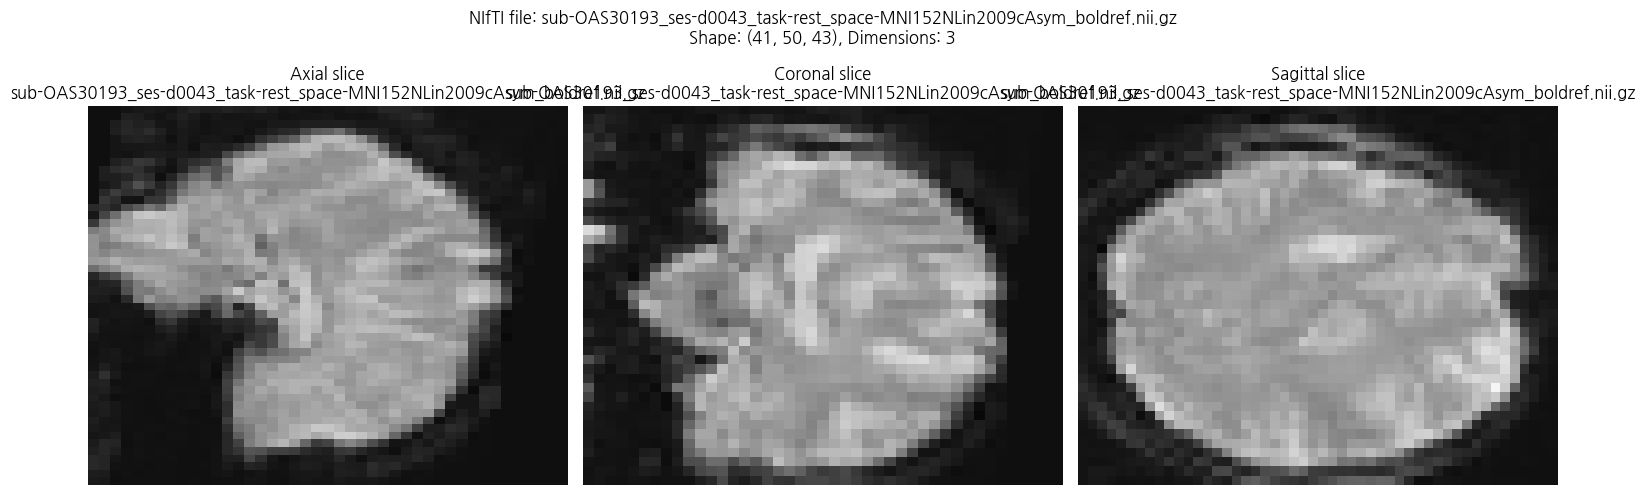

File: sub-OAS30193_ses-d0043_task-rest_desc-brain_mask.nii.gz
Shape: (64, 64, 36)
Dimensions: 3


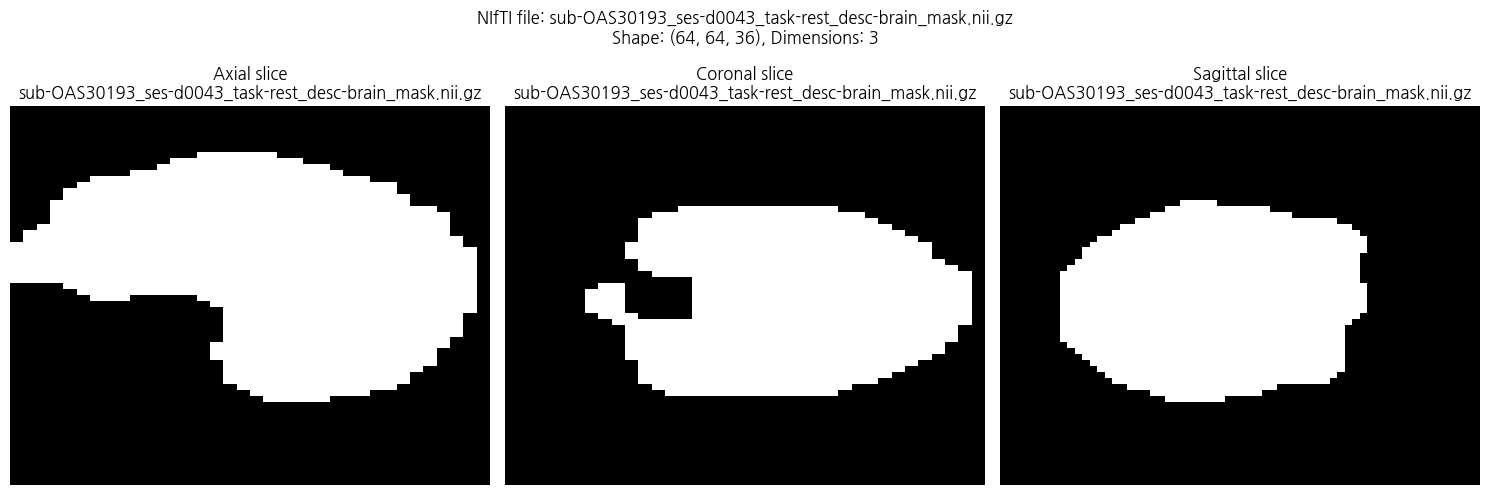

In [54]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def visualize_nifti_files(directory):
    # 디렉토리 내 모든 .nii.gz 파일 검색
    nifti_files = [f for f in os.listdir(directory) if f.endswith('.nii.gz')]

    for nifti_file in nifti_files:
        file_path = os.path.join(directory, nifti_file)
        
        # NIfTI 파일 로드
        nifti_data = nib.load(file_path)
        nifti_array = nifti_data.get_fdata()
        
        # 데이터의 크기와 차원 출력
        shape = nifti_array.shape
        print(f"File: {nifti_file}")
        print(f"Shape: {shape}")
        print(f"Dimensions: {len(shape)}")

        # 4차원 데이터인 경우, 중간 시간 지점의 3차원 볼륨 추출
        if len(shape) == 4:
            time_point = shape[-1] // 2  # 중간 시간 지점 선택
            nifti_array = nifti_array[:, :, :, time_point]
            shape = nifti_array.shape
        
        # 데이터의 중간 슬라이스 계산
        slices = [shape[0] // 2, shape[1] // 2, shape[2] // 2]

        # 시각화
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        vmin, vmax = np.min(nifti_array), np.max(nifti_array)  # 데이터 범위 설정
        
        axes[0].imshow(nifti_array[slices[0], :, :], cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
        axes[0].set_title(f'Axial slice\n{nifti_file}')
        axes[0].axis('off')
        
        axes[1].imshow(nifti_array[:, slices[1], :], cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Coronal slice\n{nifti_file}')
        axes[1].axis('off')
        
        axes[2].imshow(nifti_array[:, :, slices[2]], cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
        axes[2].set_title(f'Sagittal slice\n{nifti_file}')
        axes[2].axis('off')
        
        plt.suptitle(f"NIfTI file: {nifti_file}\nShape: {shape}, Dimensions: {len(shape)}")
        plt.tight_layout()
        plt.show()

# 디렉토리 경로 설정
directory = "/home/minyoungxi/MINYOUNGXI/XFL/OASIS_615_fmriprep_output/sub-OAS30193/ses-d0043/func"

# 시각화 함수 호출
visualize_nifti_files(directory)


##  BOLD fMRI 데이터 전처리

`sub-OAS30193_ses-d0043_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz` 파일을 로드하고 전처리
    - 시간에 따른 뇌의 활동을 측정한 데이터


`sub-OAS30193_ses-d0043_desc-preproc_T1w.nii.gz` 
    - 뇌의 해부학적 구조를 제공하며, BOLD fMRI 데이터를 정렬하거나 마스크를 생성하는 데 사용된다.

`sub-OAS30193_ses-d0043_desc-brain_mask.nii.gz`
    - 뇌 영역을 정의하고, 분석에서 비뇌 영역을 제외


2024-06-19 23:09:04.496700: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


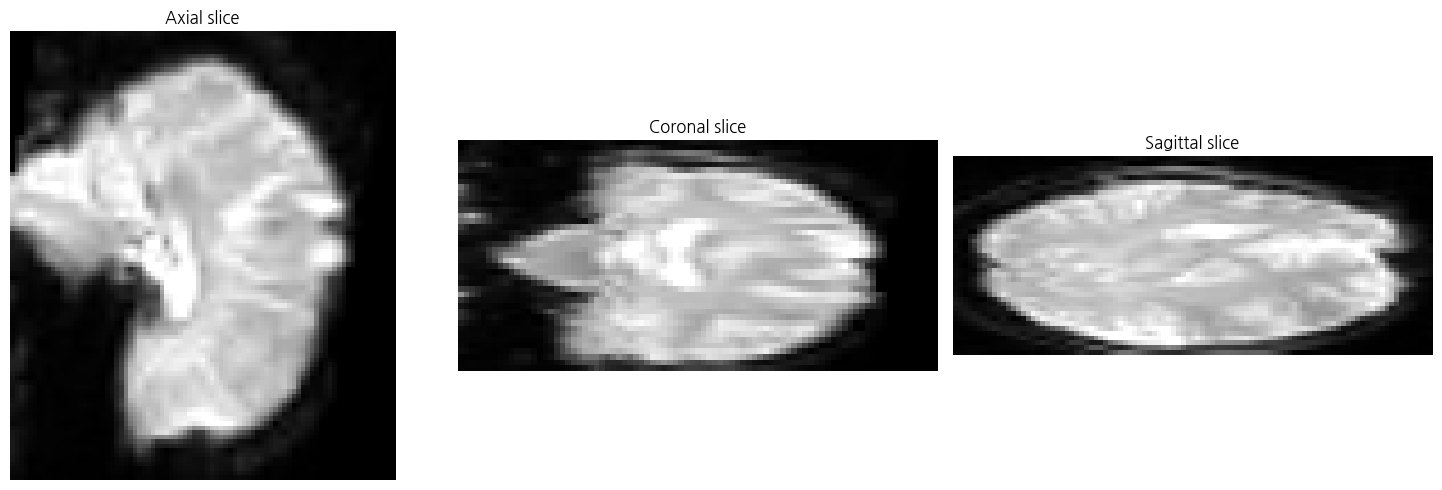

In [55]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.transforms import LoadImage, Spacing, Orientation, ScaleIntensity, EnsureChannelFirst

def resample_fmri(file_path, new_spacing=(1.0, 1.0, 1.0)):
    # Load the NIfTI file using MONAI
    load_image = LoadImage(image_only=True)
    fmri_image = load_image(file_path)
    
    # Apply the resampling transform
    resample = Spacing(pixdim=new_spacing, mode='bilinear')
    resampled_image = resample(fmri_image)
    
    return resampled_image

def visualize_slices(image, time_point):
    # Get the data array from the image
    image_data = image.numpy()
    
    # Select the 3D volume at the specified time point
    image_3d = image_data[:, :, :, time_point]
    
    # Calculate the middle slices
    slices = [image_3d.shape[0] // 2, image_3d.shape[1] // 2, image_3d.shape[2] // 2]

    # Plot the slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    vmin, vmax = np.percentile(image_3d, 1), np.percentile(image_3d, 99)
    
    axes[0].imshow(image_3d[slices[0], :, :], cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title('Axial slice')
    axes[0].axis('off')
    
    axes[1].imshow(image_3d[:, slices[1], :], cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title('Coronal slice')
    axes[1].axis('off')
    
    axes[2].imshow(image_3d[:, :, slices[2]], cmap='gray', vmin=vmin, vmax=vmax)
    axes[2].set_title('Sagittal slice')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Directory and file path settings
fmriprep_dir = "/home/minyoungxi/MINYOUNGXI/XFL/OASIS_615_fmriprep_output"
sample_subject = "sub-OAS30193"
sample_session = "ses-d0043"
func_file = os.path.join(fmriprep_dir, sample_subject, sample_session, "func",
                         f"{sample_subject}_{sample_session}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")

# Resample the fMRI data
resampled_fmri = resample_fmri(func_file, new_spacing=(2.0, 2.0, 2.0))  # Example spacing, adjust as needed

# Visualize the resampled data
time_point = resampled_fmri.shape[-1] // 2  # Choose the middle time point
visualize_slices(resampled_fmri, time_point)
